In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os

import dask

from functions import *
from functions.preprocessing import *
from functions.swing_points import *
from functions.fvg import *

quandl_api_key = '_umNYuQHdkCgs9Rcm4Fv'

In [4]:
test = False
if test:
    df_es = pd.read_csv('EP_test_set.csv', sep='\t')
    df_nq = pd.read_csv('ENQ_test_set.csv', sep='\t')
    df_es = preprocess_dataframe(df_es, log_returns=False)
    df_nq = preprocess_dataframe(df_nq, log_returns=False)
else:    
    df_es = pd.read_csv('/Users/kush/Desktop/futures_data/EP.csv', low_memory=True)
    df_nq = pd.read_csv('/Users/kush/Desktop/futures_data/ENQ.csv', low_memory=True)
    
    rows = 100000000#max(len(df_es), len(df_nq)) // 2
    df_es = df_es[-rows:]
    df_nq = df_nq[-rows:]
    
    df_es = preprocess_dataframe(df_es, log_returns=False)
    df_nq = preprocess_dataframe(df_nq, log_returns=False)


In [19]:
df_list = []
global past_swings

for df in [df_es, df_nq]:
    log_returns=False

    # Step 1: Get swing points for each window
    lookback = 20
    timeframes = ['1T', '5T', '15T', '60T', '240T', '1440T']
    print(f'Finding swing points')
    df = identify_swing_points_optimized(df, timeframes, interpolation_method='None')

    # Step 2: Get a list of the past {lookback} swing points for each time point
    print(f'Getting past {lookback} swings into list')
    df = swings_to_features_optimized(df, lookback, log_returns)
    
    # Step 4: Drop columns from Step 1 and Step 2
    print('Dropping unnecesary swings columns')
    regex_swings = r'^swing_high_\d{1,4}[TDW]$|^swing_low_\d{1,4}[TDW]$'
    pivot_cols_to_drop = [c for c in df.columns if re.match(regex_swings, c)]
    df = df.drop(columns=pivot_cols_to_drop)
    
    # convert cols dtype to save memory
    df.fillna(0, inplace=True)
    print('Converting dtypes')
    cols_to_float32 = [c for c in df.columns if any(s in c for s in ['open', 'high', 'low', 'close'])]
    df[cols_to_float32] = df[cols_to_float32].astype('float32')

    # Step 5: Get Fair Value Gaps for each timeframe
    print('Getting Fair Value Gaps')
    timeframes_fvg = ['1T', '5T', '15T', '60T', '240T', '1440T']
    df = identify_fair_value_gaps_optimized(df, timeframes_fvg)

    # Step 6: Get list of past {lookback} FVGs
    print(f'Getting past {lookback} FVGs')
    df = fvg_to_feature_optimized(df, lookback, log_returns)
    
     # Step 8:   Drop columns from Step 6 and Step 6
    print('Dropping unnecesary FVG columns')
    regex_fvg = r'^fair_value_gap_\d{1,4}[TDW]$|^fair_value_gap_\d{1,4}[TDW]_high$|^fair_value_gap_\d{1,4}[TDW]_low$'
    fvg_cols_to_drop = [c for c in df.columns if re.match(regex_fvg, c)]
    df = df.drop(columns=fvg_cols_to_drop)

    # convert cols dtype to save memory
    df.fillna(0, inplace=True)
    print('Converting dtypes')
    cols_to_float32 = [c for c in df.columns if any(s in c for s in ['open', 'high', 'low', 'close'])]
    df[cols_to_float32] = df[cols_to_float32].astype('float32')
    
    cols_to_uint16 = [c for c in df.columns if re.match(r'^fair_value_gap_\d{1,4}[TDW]_\d+$', c)]
    df[cols_to_uint16] = df[cols_to_uint16].astype('uint16')

    print('Adding DF to list \n')
    df_list.append(df)

Finding swing points
Getting past 20 swings into list
Dropping unnecesary swings columns
Converting dtypes
Getting Fair Value Gaps
Getting past 20 FVGs
Dropping unnecesary FVG columns
Converting dtypes
Adding DF to list 

Finding swing points
Getting past 20 swings into list
Dropping unnecesary swings columns
Converting dtypes
Getting Fair Value Gaps
Getting past 20 FVGs
Dropping unnecesary FVG columns
Converting dtypes
Adding DF to list 



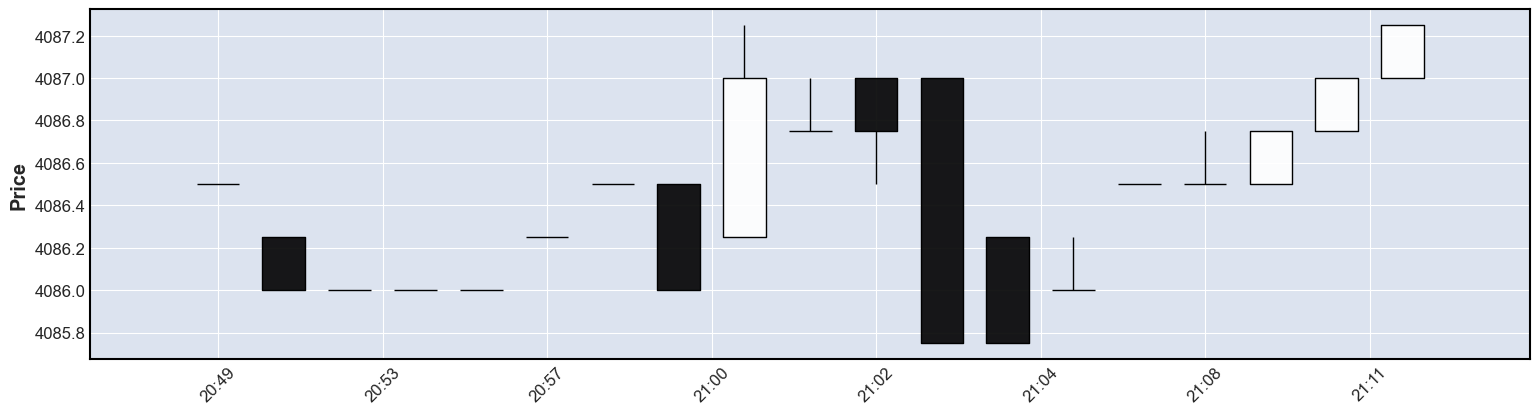

In [34]:
df_temp = df_nq.loc['2014-09-08 20:49:00':'2014-09-08 21:11:00']
#apd = [mpf.make_addplot(df_temp['swing_points_15'], color='red', secondary_y=False),
#       mpf.make_addplot(df_temp['swing_points_5_next_swing'], color='b', linestyle='dotted', secondary_y=False)]

mpf.plot(df_temp, type='candle', figsize=(20,5))

# DATAFRAME IS READY, NEXT STEP IS TO DO THE MACHINE LEARNING
# TRY IT LOCALLY THEN GO TO SAGEMAKER (DEPENDING ON HOW LOCALLY GOES)

In [20]:
# combine dataset
df = pd.merge(df_list[0], df_list[1], 'inner', 'datetime', suffixes=('_es', '_nq'))
#del(df_es)
#del(df_nq)

# extract year, month, day, hour, minute, and day of week as separate reatures.
df = df.assign(
    year=df.index.year,
    month=df.index.month,
    day=df.index.day,
    date=df.index.date,
    hour=df.index.hour,
    minute=df.index.minute,
    day_of_week=df.index.dayofweek,
    day_of_the_week=df.index.dayofweek #pd.get_dummies (below) removes the 'day_of_week' column to one-hot-encode, but we still need it for the df_filtered code.
)
df['day_of_the_week'] = df['day_of_week']
df = pd.get_dummies(df, 'day_of_week', columns=['day_of_week'])





# dataframe is fragemented, t de-fragment it use copy.
#df = df.copy(deep=True)

/var/folders/8h/72mwhy0j2fd18ttn3cpr4xnw0000gp/T/ipykernel_69028/1756083676.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df = pd.merge(df_list[0], df_list[1], 'inner', 'datetime', suffixes=('_es', '_nq'))


In [21]:
##### CALUCLATE NWOGS and get add past 5 to each time point #####

# Resample to daily frequency and backfill the OHLC into the weekends.
daily_df = df.resample('D').agg({'open_es': 'first', 'high_es' : 'max', 'low_es' : 'min', 'close_es': 'last'}).bfill()

# Identify closing prices on Fridays
friday_closes = daily_df[daily_df.index.dayofweek == 4]['close_es']

# Identify opening prices on Sundays
# since we backfilled, the next market opening price will be the opening price on saturday. shift it up one to match the friday index
# then we have the friday close and next market open on the same index.
sunday_opening = daily_df['open_es'].shift(-1) #
sunday_opening = sunday_opening[sunday_opening.index.dayofweek == 4]

# convert to dataframe and get log returns
nwog_df = pd.DataFrame({'NWOG_close': np.log(friday_closes / friday_closes.shift(1)), 'NWOG_open': np.log(sunday_opening / sunday_opening.shift(1))})

# Create columns for the past 5 closes and openings
for i in range(1, 6):
    nwog_df[f'NWOG_close_{i}'] = nwog_df['NWOG_close'].shift(i)
    nwog_df[f'NWOG_open_{i}'] = nwog_df['NWOG_open'].shift(i)

# Drop the original 'NWOG_close' and 'NWOG_open' columns
nwog_df.drop(columns=['NWOG_close', 'NWOG_open'], inplace=True)

df = df.join(nwog_df, how='left').fillna(method='ffill')

In [22]:
# GET DAILY HIGH AND LOW BEFORE LUNCH

# Filter data, calculate daily high and low and their times, and merge back to original DataFrame
filtered_df = df[df.day_of_the_week < 5].between_time('09:30', '11:59')
morning_high_low = filtered_df.groupby('date').agg({'high_es': 'max', 'low_es': 'min'})
morning_high_low.columns = ['Morning_High', 'Morning_Low']

# Get Daily High and Low
filtered_df = df[df.day_of_the_week < 5].between_time('09:30', '15:59')
daily_high_low = filtered_df.groupby('date').agg({'high_es': 'max', 'low_es': 'min'})
daily_high_low.columns = ['Daily_High', 'Daily_Low']
morning_high_low = morning_high_low.join(daily_high_low)

# Get Daily Midnight Open
morning_high_low = morning_high_low.join(df[(df.hour == 0) & (df.minute == 0)][['open_es', 'date']].set_index('date')).rename({'open_es' : 'Midnight_Open'}, axis='columns')

df = df.merge(morning_high_low, how='left', on='date')

# GET ONLY 0929 TIMEPOINTS FOR EACH DAY
df_final = df[(df.hour == 9) & (df.minute == 29)].reset_index().dropna()

# convert daily high and low and midnight variables to log return of the close price at 9:29
df_final[['Daily_High', 'Daily_Low']] = df_final[['Daily_High', 'Daily_Low']].div(df_final.close_es, axis=0).apply(np.log)
df_final[['Morning_High', 'Morning_Low']] = df_final[['Morning_High', 'Morning_Low']].div(df_final.close_es, axis=0).apply(np.log)
df_final['Midnight_Open'] = df_final['Midnight_Open'].div(df_final.close_es, axis=0).apply(np.log)

# convert the rest of the price columns to log returns of the close price at 9:29
price_cols = [c for c in df_final.columns if any(s in c for s in ['swing', 'fair', 'NWOG'])]
df_final[price_cols] = df_final[price_cols].div(df_final.close_es, axis=0).apply(np.log)


# convert OHLC log returns based on previous day's 0929 candle
df_final = calculate_log_returns(df_final, ['open_es', 'high_es', 'low_es', 'close_es'])
df_final = calculate_log_returns(df_final, ['open_nq', 'high_nq', 'low_nq', 'close_nq'])


# Transform 'month' variable (max value is 12)
df_final['month_sin'] = np.sin(2 * np.pi * df_final['month'] / 12)
df_final['month_cos'] = np.cos(2 * np.pi * df_final['month'] / 12)

# Transform 'day' variable (max value is 31)
df_final['day_sin'] = np.sin(2 * np.pi * df_final['day'] / 31)
df_final['day_cos'] = np.cos(2 * np.pi * df_final['day'] / 31)

# Drop unnecesary columns
df_final.drop(columns=['day_of_week_6', 'day_of_the_week', 'date', 'hour', 'minute', 'index'], inplace=True)

/Users/kush/Documents/DS/daily_high_low/functions/preprocessing.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[log_return_column] = np.log(df[column] / df[column].shift(1))
/Users/kush/Documents/DS/daily_high_low/functions/preprocessing.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[log_return_column] = np.log(df[column] / df[column].shift(1))
/Users/kush/Documents/DS/daily_high_low/functions/preprocessing.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

In [24]:
df_final.to_csv('df_final_test.csv', index=False)